In [1]:
import os
import numpy as np
import json
import pandas as pd

import matplotlib 
matplotlib.use('SVG')

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 3)

# UNCOMMENT TO ENABLE INTERACTIVITY
# import mpld3
# mpld3.enable_notebook()

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
class Session:
    """
    Class for session json-files handling.
    
    Public methods:
    .load(), 
    .plot(),
    .calculate_stats();
    
    Public attributes:
    .session, 
    .info,
    .results, 
    .n_gestures, 
    .probs;
    .stats;
    """
    
    def __init__(self, path=None):
        
        self.session = None
        self.info = {}
        self.results = []
        self.n_gestures = 0
        self.probs = {}
        self.stats = {}
        
        if path is not None:
            self.load(path)
            
    
    def _fill_info_(self, fields="all"):
        
        if fields == "all":
            fields_to_fill = ["progress", "skippedGesturesNumber", "startDateTime"]
        elif isinstance(fields, (list, tuple)):
            fields_to_fill = fields
        else:
            raise ValueError("Incorrect :fields: argument: no such field in session file: {}".format(fields))
        
        for field in fields_to_fill:
            if field in self.session.keys():
                self.info.update({field: self.session[field]})
            else:
                print field
        
        self.info.update({"n_gestures": self.n_gestures})
                
        return self.info
    
    
    def _fill_exercise_info_(self, fields="all"):
        
        if fields == "all":
            fields_to_fill = ["id", "name", "description", "instruction", "mode", "type", "instructionTime"]
        elif isinstance(fields, (list, tuple)):
            fields_to_fill = fields
        else:
            raise ValueError("Incorrect :fields: argument: no such field in session file: {}".format(fields))
        
        for field in fields_to_fill:
            if field in self.session['exercise'].keys():
                self.info.update({"exercise_" + field: self.session['exercise'][field]})
            else:
                print field
                
        return self.info
    
    
    def _calculate_n_gestures_(self):
        
        for result in self.results:
            if "lp" in result:
                return len(result["lp"])
            elif "rp" in result:
                return len(result["rp"])
        raise ValueError("No successful frames read")
        
        
    def calculate_stats(self, stats="all"):
        
        if stats == "all":
            stats_to_calc = ["speed"]
        elif stats == "speed":
            stats_to_calc = ["speed"]
        else:
            raise ValueError("Incorrect :stats: argument: must be \"all\" or \"speed\"")
        
        if "speed" in stats_to_calc:
            self.stats.update({"speed": np.round(self.session["speed"], 3)})
        
        return self.stats

    
    def load(self, path):
        
        if not os.path.isfile(path):
            raise OSError("File not found")
        with open(path, 'r') as f:
            self.session = json.load(f)
        print("Session file successfully loaded")

        self.results = [j for j in self.session['resultsList']]
        self.n_gestures = self._calculate_n_gestures_()
        self.info = self._fill_info_()
        self.info = self._fill_exercise_info_()
        print("Session of type {}, found {} frames".format(self.session['exercise']['id'], len(self.results)))
        
        for hand in ["lp", "rp"]:
            probs = np.zeros(shape=(self.n_gestures, len(self.results)), dtype=np.double)
            for r, result in enumerate(self.results):
                if hand in result.keys():
                    for g in xrange(self.n_gestures):
                        probs[g, r] = result[hand][g]
                else:
                    for g in xrange(self.n_gestures):
                        probs[g, r] = 0.
            self.probs.update({hand : probs})
        
        
    def plot(self, gestures="all", hands="all", separate=None):
        
        if gestures == "all":
            gestures_to_plot = range(self.n_gestures)
        elif isinstance(gestures, (list, tuple)):
            gestures_to_plot = gestures
        elif isinstance(gestures, int):
            gestures_to_plot = [gestures]
        else:
            raise ValueError("Incorrect :gestures: argument: must be int or list of ints")
        
        if hands == "all":
            hands_to_plot = ["lp", "rp"]
        elif hands == "left":
            hands_to_plot = ["lp"]
        elif hands == "right":
            hands_to_plot = ["rp"]
        else:
            raise ValueError("Incorrect :hands: argument: must be \"all\", \"left\" or \"right\"")
        
        if separate == "gestures":
            for gesture in gestures_to_plot:
                fig = plt.figure()
                plt.title("Plotting \"{}\" gesture for {} hand(s)".format(gesture, hands))
                for hand in hands_to_plot:
                    plt.plot(self.probs[hand][gesture], label="{}, {}".format(gesture, hand))
                plt.legend(bbox_to_anchor = (-0.05, -0.05), loc="upper left", ncol = len(gestures_to_plot) / 8 + int(len(gestures_to_plot) / 8 == 0))
                plt.show()
        elif separate == "hands":
            for hand in hands_to_plot:
                fig = plt.figure()
                plt.title("Plotting {} gestures for {} hand".format(gestures_to_plot, hand))
                for gesture in gestures_to_plot:
                    plt.plot(self.probs[hand][gesture], label="{}, {}".format(gesture, hand))
                plt.legend(bbox_to_anchor = (-0.05, -0.05), loc="upper left", ncol = len(gestures_to_plot) / 8 + int(len(gestures_to_plot) / 8 == 0))
                plt.show()
        elif separate == "all":
            for hand in hands_to_plot:
                for gesture in gestures_to_plot:
                    fig = plt.figure()
                    plt.title("Plotting \"{}\" gesture for {} hand".format(gesture, hand))
                    plt.plot(self.probs[hand][gesture], label="{}, {}".format(gesture, hand))
                plt.legend(bbox_to_anchor = (-0.05, -0.05), loc="upper left", ncol = len(gestures_to_plot) / 8 + int(len(gestures_to_plot) / 8 == 0))                
                plt.show()
        else:
            raise ValueError("Incorrect :separate: argument: must be \"all\", \"hands\" or \"gestures\"")    


Загрузка файла с сессией:

In [3]:
session = Session()
session.load("../etc/session.json")

Session file successfully loaded
Session of type 1, found 432 frames


Вывод информации о сессии:

In [4]:
for key, value in sorted(session.info.iteritems()):
    print(u"{:<25} : {:<25}".format(key, value))

exercise_description      : Кулак-ладонь             
exercise_id               : 1                        
exercise_instruction      : Упражнения состоит из трех этапов
 1. Для левой руки
 2. Для правой руки
 3. Для обеих

exercise_instructionTime  : 5                        
exercise_mode             : time                     
exercise_name             : Упражнение 1             
exercise_type             : first                    
n_gestures                : 17                       
progress                  : 74                       
skippedGesturesNumber     : 0                        
startDateTime             : 2017-08-12T01:31:58.155+03:00[Europe/Moscow]


Построение графиков вероятностей отдельно для жестов и отдельно для рук:

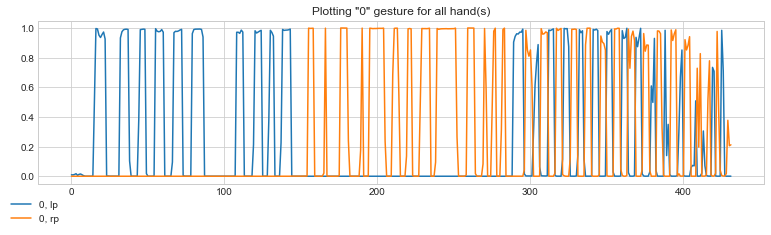

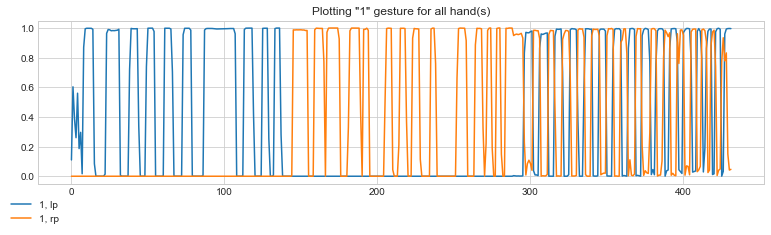

In [5]:
session.plot(gestures=[0, 1], hands="all", separate="gestures")

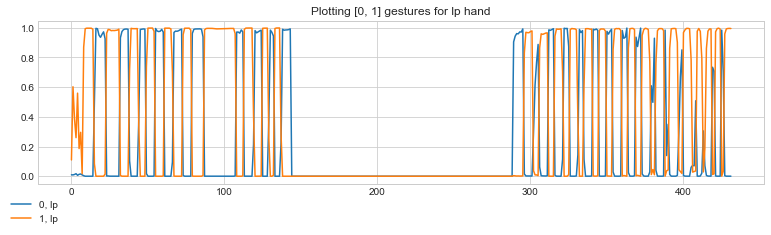

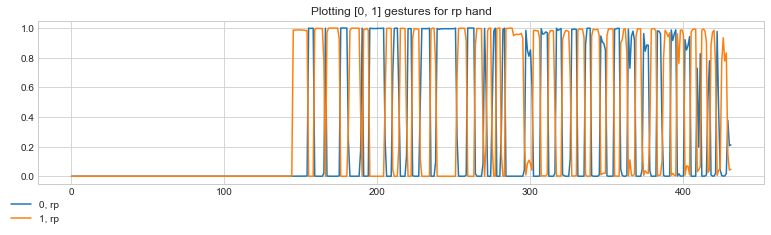

In [6]:
session.plot(gestures=[0, 1], hands="all", separate="hands")

Вычисление статистик по наборам вероятностей:

In [7]:
session.calculate_stats()

{'speed': 1.347}